In [72]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [73]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

import gc
import pickle as pickle


from sklearn.model_selection import KFold
from itertools import product
import tensorflow as tf

In [74]:
gc.collect()

items           = pd.read_csv('items.csv',usecols=["item_id", "item_category_id"])
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train.csv.gz')
test            = pd.read_csv('test.csv.gz')

In [75]:
sales_train[['day','month', 'year']] = sales_train['date'].str.split('.', expand=True).astype(int)
sales_train = sales_train[sales_train['year'].isin([2013,2014]) == False]
sales_train = sales_train.set_index('item_id').join(items.set_index('item_id'))
sales_train.reset_index(inplace=True)

In [76]:
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [77]:
max_sales=1000
sums = sales_train.groupby('item_id')['item_cnt_day'].sum().reset_index().rename(columns={"item_cnt_day":"item_total_sales"}).sort_values(by='item_total_sales')

ids_keep = sums[(sums['item_total_sales'] > 0) & (sums['item_total_sales'] < max_sales)]['item_id'].unique()

In [78]:
#train_item_ids = sales_train['item_id'].unique()
#train_item_ids = np.setdiff1d(train_item_ids, ids_reject)
train_item_ids = ids_keep
train_shop_ids = sales_train['shop_id'].unique()
test_item_ids = test['item_id'].unique()
test_shop_ids = test['shop_id'].unique()
train_blocks = sales_train['date_block_num'].unique()

all_item_ids = np.unique(np.append(test_item_ids,train_item_ids))
all_shop_ids = np.unique(np.append(train_shop_ids,test_shop_ids))


In [79]:
combinations = []

for dbn in range(np.min(train_blocks), np.max(train_blocks)+1):
    sales = sales_train[sales_train.date_block_num==dbn]
    #item_ids = np.intersect1d(sales.item_id.unique(), test_item_ids)
    item_ids = all_item_ids
    #dbn_combos = list(product(sales.shop_id.unique(), item_ids, [dbn]))
    dbn_combos = list(product(all_shop_ids, item_ids, [dbn]))
    for combo in dbn_combos:
        combinations.append(combo)
        
all_combos = pd.DataFrame(np.unique(np.vstack([combinations]), axis=0), columns=['shop_id','item_id','date_block_num'])

In [80]:
ys = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_item_cnt_block"})

training = all_combos.merge(ys, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)


training['shop_item_cnt_block'] = training['shop_item_cnt_block'].clip(0,20).astype('int8')

training = training.set_index('item_id').join(items.set_index('item_id'))
training.reset_index(inplace=True)

for col in ['item_id', 'shop_id', 'item_category_id']:
    training[col] = pd.to_numeric(training[col], downcast='unsigned')

In [81]:
dates = sales_train[['date_block_num', 'month', 'year']].drop_duplicates(['date_block_num', 'month', 'year'])

dates_dict = {}

for index,row in dates.iterrows():
    dates_dict[row['date_block_num']] = {"month": row['month'], "year": row['year']}
    
training['month'] = pd.to_numeric(training['date_block_num'].apply(lambda block: dates_dict[block]['month']), downcast='unsigned')
training['year'] = pd.to_numeric(training['date_block_num'].apply(lambda block: dates_dict[block]['year']), downcast='unsigned')



In [ ]:
#training = training[(~training['date_block_num'].isin([22,23]))]

In [82]:
ys = sales_train.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"item_cnt_block"})

training = training.merge(ys, on=['item_id', 'date_block_num'], how='left').fillna(0)

ys = sales_train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_cnt_block"})

training = training.merge(ys, on=['shop_id', 'date_block_num'], how='left').fillna(0)


ys = sales_train.groupby(['item_category_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"category_cnt_block"})


training = training.merge(ys, on=['item_category_id', 'date_block_num'], how='left').fillna(0)


ys = sales_train.groupby(['shop_id', 'item_category_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_category_cnt_block"})

training = training.merge(ys, on=['shop_id', 'item_category_id', 'date_block_num'], how='left').fillna(0)


In [83]:
training[(training['shop_id'] == 2) & (training['item_id'] == 10)]

,item_id,shop_id,date_block_num,shop_item_cnt_block,item_category_id,month,year,item_cnt_block,shop_cnt_block,category_cnt_block,shop_category_cnt_block
0,10,2,24,0,40,1,2015,1.0,987.0,15109.0,57.0
1,10,2,25,0,40,2,2015,0.0,907.0,12100.0,68.0
2,10,2,26,0,40,3,2015,0.0,762.0,13084.0,68.0
3,10,2,27,0,40,4,2015,0.0,859.0,10683.0,83.0
4,10,2,28,0,40,5,2015,0.0,843.0,9208.0,58.0
5,10,2,29,0,40,6,2015,0.0,804.0,9304.0,59.0
6,10,2,30,0,40,7,2015,0.0,785.0,9283.0,68.0
7,10,2,31,0,40,8,2015,0.0,942.0,8513.0,83.0
8,10,2,32,0,40,9,2015,0.0,822.0,6779.0,46.0
9,10,2,33,0,40,10,2015,0.0,727.0,7680.0,74.0


In [84]:
training['item_cnt_block_mean'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.mean)
training['item_cnt_block_min'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.min)
training['item_cnt_block_max'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.max)
training['item_cnt_block_std'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.std)
training['item_cnt_block_med'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.median)

In [85]:
training['shop_cnt_block_mean'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.mean)
training['shop_cnt_block_min'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.min)
training['shop_cnt_block_max'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.max)
training['shop_cnt_block_std'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.std)
training['shop_cnt_block_med'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.median)

In [86]:
training['category_cnt_block_mean'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.mean)
training['category_cnt_block_min'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.min)
training['category_cnt_block_max'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.max)
training['category_cnt_block_std'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.std)
training['category_cnt_block_med'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.median)

In [87]:
training['shop_category_cnt_block_mean'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.mean)
training['shop_category_cnt_block_min'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.min)
training['shop_category_cnt_block_max'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.max)
training['shop_category_cnt_block_std'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.std)
training['shop_category_cnt_block_med'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.median)

In [88]:
training['shop_item_cnt_block_mean'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.mean)
training['shop_item_cnt_block_min'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.min)
training['shop_item_cnt_block_max'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.max)
training['shop_item_cnt_block_std'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.std)
training['shop_item_cnt_block_med'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.median)

In [89]:

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
training.sample(10)

,item_id,shop_id,date_block_num,shop_item_cnt_block,item_category_id,month,year,item_cnt_block,shop_cnt_block,category_cnt_block,shop_category_cnt_block,item_cnt_block_mean,item_cnt_block_min,item_cnt_block_max,item_cnt_block_std,item_cnt_block_med,shop_cnt_block_mean,shop_cnt_block_min,shop_cnt_block_max,shop_cnt_block_std,shop_cnt_block_med,category_cnt_block_mean,category_cnt_block_min,category_cnt_block_max,category_cnt_block_std,category_cnt_block_med,shop_category_cnt_block_mean,shop_category_cnt_block_min,shop_category_cnt_block_max,shop_category_cnt_block_std,shop_category_cnt_block_med,shop_item_cnt_block_mean,shop_item_cnt_block_min,shop_item_cnt_block_max,shop_item_cnt_block_std,shop_item_cnt_block_med
5052626,17989,18,30,0,40,7,2015,8.0,987.0,9283.0,68.0,5.370579,-2.0,3347.0,36.367840,0.0,1192.207547,0.0,5987.0,1142.475219,993.0,3306.340851,0.0,9283.0,3375.934938,1817.0,62.383790,-1.0,1475.0,136.777158,12.0,0.095295,0,20,0.611902,0
1929542,6692,41,26,0,19,3,2015,2.0,848.0,3737.0,44.0,6.981462,-1.0,1924.0,32.179666,1.0,1547.433962,0.0,7294.0,1458.272373,1199.0,4629.500000,0.0,13084.0,4726.444944,1714.0,87.349057,-1.0,2074.0,201.582817,18.0,0.123750,0,20,0.737110,0
1269685,4339,40,29,0,24,6,2015,5.0,0.0,877.0,0.0,5.461131,-2.0,3473.0,39.087494,0.0,1209.698113,0.0,6160.0,1229.358494,953.0,3332.258585,0.0,9304.0,3365.863203,1425.0,62.872803,-1.0,1529.0,146.676700,11.0,0.095320,0,20,0.648273,0
5792366,20729,59,30,0,72,7,2015,0.0,992.0,1411.0,13.0,5.370579,-2.0,3347.0,36.367840,0.0,1192.207547,0.0,5987.0,1142.475219,993.0,3306.340851,0.0,9283.0,3375.934938,1817.0,62.383790,-1.0,1475.0,136.777158,12.0,0.095295,0,20,0.611902,0
2302803,8117,55,27,0,58,4,2015,1.0,3422.0,389.0,0.0,6.527934,-1.0,7300.0,82.653775,0.0,1468.433962,-1.0,7341.0,1449.021689,1110.0,4058.271741,0.0,14751.0,4171.199463,2506.0,76.571165,-1.0,2506.0,189.136108,13.0,0.100655,0,20,0.712728,0
2414252,8477,15,26,0,43,3,2015,0.0,1384.0,449.0,0.0,6.981462,-1.0,1924.0,32.179666,1.0,1547.433962,0.0,7294.0,1458.272373,1199.0,4629.500000,0.0,13084.0,4726.444944,1714.0,87.349057,-1.0,2074.0,201.582817,18.0,0.123750,0,20,0.737110,0
4640852,16379,22,26,0,31,3,2015,0.0,1547.0,1679.0,0.0,6.981462,-1.0,1924.0,32.179666,1.0,1547.433962,0.0,7294.0,1458.272373,1199.0,4629.500000,0.0,13084.0,4726.444944,1714.0,87.349057,-1.0,2074.0,201.582817,18.0,0.123750,0,20,0.737110,0
5480966,19618,29,30,0,37,7,2015,3.0,0.0,3291.0,0.0,5.370579,-2.0,3347.0,36.367840,0.0,1192.207547,0.0,5987.0,1142.475219,993.0,3306.340851,0.0,9283.0,3375.934938,1817.0,62.383790,-1.0,1475.0,136.777158,12.0,0.095295,0,20,0.611902,0
3955723,14147,40,27,0,55,4,2015,7.0,0.0,7162.0,0.0,6.527934,-1.0,7300.0,82.653775,0.0,1468.433962,-1.0,7341.0,1449.021689,1110.0,4058.271741,0.0,14751.0,4171.199463,2506.0,76.571165,-1.0,2506.0,189.136108,13.0,0.100655,0,20,0.712728,0
2719873,9726,51,27,0,41,4,2015,0.0,494.0,658.0,3.0,6.527934,-1.0,7300.0,82.653775,0.0,1468.433962,-1.0,7341.0,1449.021689,1110.0,4058.271741,0.0,14751.0,4171.199463,2506.0,76.571165,-1.0,2506.0,189.136108,13.0,0.100655,0,20,0.712728,0


In [90]:
features = [
    
        'item_cnt_block',
       'shop_cnt_block', 'category_cnt_block', 'shop_category_cnt_block',
       'item_cnt_block_mean', 'item_cnt_block_min', 'item_cnt_block_max',
       'item_cnt_block_std', 'item_cnt_block_med', 'shop_cnt_block_mean',
       'shop_cnt_block_min', 'shop_cnt_block_max', 'shop_cnt_block_std',
       'shop_cnt_block_med', 'category_cnt_block_mean',
       'category_cnt_block_min', 'category_cnt_block_max',
       'category_cnt_block_std', 'category_cnt_block_med',
       'shop_category_cnt_block_mean', 'shop_category_cnt_block_min',
       'shop_category_cnt_block_max', 'shop_category_cnt_block_std',
       'shop_category_cnt_block_med'
    #'shop_item_cnt_block_mean',
     #  'shop_item_cnt_block_min', 'shop_item_cnt_block_max',
      # 'shop_item_cnt_block_std', 'shop_item_cnt_block_med'
]

In [91]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler 


training[features] = StandardScaler().fit_transform(training[features])



In [92]:
training[features] = training[features].apply(pd.to_numeric, downcast='float')

In [93]:
training[features].sample(10)

,item_cnt_block,shop_cnt_block,category_cnt_block,shop_category_cnt_block,item_cnt_block_mean,item_cnt_block_min,item_cnt_block_max,item_cnt_block_std,item_cnt_block_med,shop_cnt_block_mean,shop_cnt_block_min,shop_cnt_block_max,shop_cnt_block_std,shop_cnt_block_med,category_cnt_block_mean,category_cnt_block_min,category_cnt_block_max,category_cnt_block_std,category_cnt_block_med,shop_category_cnt_block_mean,shop_category_cnt_block_min,shop_category_cnt_block_max,shop_category_cnt_block_std,shop_category_cnt_block_med
4737968,-0.008206,-1.003232,-0.688233,-0.420541,-0.701920,0.333333,-0.442311,-0.408404,-0.654654,-0.271016,-2.0,0.058412,0.842508,-0.368823,-1.253335,0.333333,-1.268627,-1.405324,-0.771865,-1.253335,-0.654654,2.015496,-1.205614,-0.813634
2644981,-0.121284,0.074681,-0.476839,-0.273185,0.657712,0.333333,-0.599460,-0.632058,1.527525,0.580173,0.5,0.668666,0.123112,1.010576,0.740910,0.333333,0.537599,0.750076,-0.129986,0.740910,1.527525,-0.550714,0.393829,1.260335
356169,-0.121284,-0.497656,-0.718800,-0.379282,-0.317366,0.333333,-0.057547,0.002756,-0.654654,-0.404973,0.5,-0.646165,-0.193306,-0.619623,-0.753794,-3.000000,-1.061344,-1.118005,0.149705,-0.753794,-0.654654,0.015204,-0.667550,-0.654098
1521600,-0.008206,1.877926,-0.708268,-0.172983,2.561552,0.333333,2.062571,1.729144,1.527525,2.587122,0.5,2.272146,2.295285,2.220317,2.197469,0.333333,1.626111,1.882604,2.786642,2.197469,1.527525,1.781296,2.317133,2.377088
5199452,-0.121284,-1.003232,2.389446,-0.420541,0.474453,0.333333,-1.262172,-1.040139,1.527525,0.416457,0.5,0.543660,0.278945,0.464718,1.020770,0.333333,0.893563,1.199685,-0.342269,1.020770,-0.654654,-0.330336,0.872279,0.462655
705849,-0.102438,-0.230612,-0.700049,-0.420541,-0.317366,0.333333,-0.057547,0.002756,-0.654654,-0.404973,0.5,-0.646165,-0.193306,-0.619623,-0.753794,-3.000000,-1.061344,-1.118005,0.149705,-0.753794,-0.654654,0.015204,-0.667550,-0.654098
3519992,-0.045898,-0.652041,2.389446,0.068682,0.474453,0.333333,-1.262172,-1.040139,1.527525,0.416457,0.5,0.543660,0.278945,0.464718,1.020770,0.333333,0.893563,1.199685,-0.342269,1.020770,-0.654654,-0.330336,0.872279,0.462655
3470071,0.161412,0.275660,2.136697,0.929243,0.657712,0.333333,-0.599460,-0.632058,1.527525,0.580173,0.5,0.668666,0.123112,1.010576,0.740910,0.333333,0.537599,0.750076,-0.129986,0.740910,1.527525,-0.550714,0.393829,1.260335
4209992,-0.121284,0.030174,-0.540026,-0.420541,0.474453,0.333333,-1.262172,-1.040139,1.527525,0.416457,0.5,0.543660,0.278945,0.464718,1.020770,0.333333,0.893563,1.199685,-0.342269,1.020770,-0.654654,-0.330336,0.872279,0.462655
302133,-0.121284,-0.270251,-0.954853,-0.420541,0.080399,0.333333,1.744357,1.880623,-0.654654,0.102593,-2.0,0.597072,0.234224,-0.191788,0.333221,0.333333,1.496603,0.545974,0.454547,0.333221,-0.654654,0.001382,0.590487,-0.335026


In [94]:
dbns = sorted(training.date_block_num.unique())

windows = []
for i,_ in enumerate(dbns):
    if (i+4) <= len(dbns):
        window = dbns[i:i+4]
        windows.append(window)    
        
windows

[[24, 25, 26, 27],
 [25, 26, 27, 28],
 [26, 27, 28, 29],
 [27, 28, 29, 30],
 [28, 29, 30, 31],
 [29, 30, 31, 32],
 [30, 31, 32, 33]]

In [95]:
#groups
lstm_data = []
lstm_y = []

for window in windows:
    print(window)
    a = training[training['date_block_num'].isin(window)][['shop_item_cnt_block'] + ['date_block_num','item_id', 'shop_id'] + features]\
                    .sort_values(by=["date_block_num"]).groupby(["item_id", "shop_id"])

    for name, group in a:
        #print(group.values)
        steps = []
        ys = []
        #print("group.values",group.values)
        for step in group.values:
            #print(step)
            #print("step", len(step))
            #step is np.array 
            #step[4:] is np.array print(type(step[4:]))
            steps.append(step[4:])
            #print(step[9])
            #print(step[0])
            ys.append(step[0])
        #remove last
        #print(type(steps[0:8]))
        #jan to sept, y = oct
        lstm_data.append(np.array(steps[0:3]))
        #remove first
        #print(ys)
        #preditct for setptember
        lstm_y.append(ys[-1])
    
lstm_y = np.array([np.array([y]) for y in lstm_y])

[24, 25, 26, 27]
[25, 26, 27, 28]
[26, 27, 28, 29]
[27, 28, 29, 30]
[28, 29, 30, 31]
[29, 30, 31, 32]
[30, 31, 32, 33]


In [119]:
small_data = np.array(lstm_data)
small_y = np.array(lstm_y)

In [106]:
print(len(lstm_y))

print(len([y for y in lstm_y if y == 0]))

zeros_indices = {}
for idx,y in enumerate(lstm_y):
    
    if y == 0:
        zeros_indices[idx] = True

4342926
4118386


In [136]:
lstm_data_no_zeros = []
lstm_y_no_zeros = []
for idx,sample in enumerate(lstm_data):
    if idx not in zeros_indices:
        lstm_data_no_zeros.append(sample)
        lstm_y_no_zeros.append(lstm_y[idx])

In [137]:
lstm_zeros = []
for idx,y in enumerate(lstm_y):
    if idx in zeros_indices:
        lstm_zeros.append(idx)

In [138]:
#print(len(lstm_data_no_zeros))

for zero_idx in np.random.choice(lstm_zeros,1000000,replace=False):
    lstm_data_no_zeros.append(lstm_data[zero_idx])
    lstm_y_no_zeros.append(lstm_y[zero_idx])

In [140]:
small_data = np.array(lstm_data_no_zeros)
small_y = np.array(lstm_y_no_zeros)

In [142]:
from sklearn.model_selection import train_test_split

train_data, val_data, y_train, y_val = train_test_split(small_data, small_y, test_size=0.1, random_state=42)

In [66]:
np.array(lstm_data).shape

(4342926, 3, 28)

In [110]:
train_data.shape

(202086, 3, 24)

In [68]:
y_train.shape

(3474340, 1)

In [139]:
np.mean(lstm_y_no_zeros)

0.34358452970094894

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_17 (GRU)                 (None, 8)                 792       
_________________________________________________________________
dropout_26 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 9         
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Train on 1102086 samples, validate on 122454 samples
Epoch 1/100
1102086/1102086 [==============================] - 94s 86us/step - loss: 1.1981 - mean_squared_error: 1.1981 - val_loss: 1.0010 - val_mean_squared_error: 1.0010
Epoch 2/100
1102086/1102086 [==============================] - 91s 83us/step - loss: 1.1091 - mean_squared_error: 1.1091 - val_loss: 0.9691 - val_mean_squared_error: 0.9691
Epoch 3/1

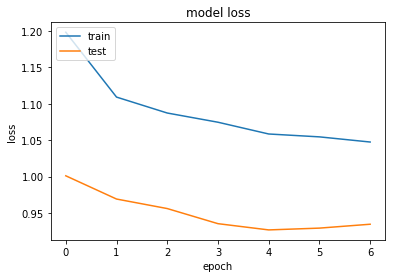

best rmse val: 0.9666871873098342


In [147]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten,GRU
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization


#x_train_scaled = MinMaxScaler().fit_transform(x_train[features])


#x_reshaped = np.reshape(x_train_scaled, (x_train_scaled.shape[0], 10, x_train_scaled.shape[1]))
    
#x_val_scaled_reshaped = np.reshape(x_val_scaled, (x_val_scaled.shape[0], 1, x_val_scaled.shape[1]))


callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0)
]

dropout=0.2

my_model = Sequential()
#bi directional?
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 64, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features)), return_sequences=True))
#my_model.add(BatchNormalization())
#my_model.add(Dropout(dropout))
my_model.add(GRU(use_bias = True,units = 8, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features))))
#my_model.add(BatchNormalization())
my_model.add(Dropout(dropout))
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 48, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features)), return_sequences=True))
#my_model.add(Dropout(dropout))
#my_model.add(BatchNormalization())
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 64, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features))))
#my_model.add(BatchNormalization())
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 4, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features))))
#my_model.add(Dropout(dropout))
#my_model.add(BatchNormalization())
my_model.add(Dense(1))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()


#lstmd_dataa = np.array(np.array(lstm_data)).reshape(271148,8,51)
#print(lstmd_dataa.shape)
#print(lstmd_dataa)
#lstm_yy = np.array([np.array([y]) for y in lstm_y[0:100]])
#print(lstm_yy.shape)
#print(lstm_yy)

history = my_model.fit(train_data, y_train, batch_size=128, epochs=100,
                      validation_data=(val_data,y_val), callbacks=callbacks
                      )


import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

import math
print("best rmse val:", math.sqrt(my_model.history.history['val_mean_squared_error'][-1]))

In [ ]:
training_test = training[(training['shop_id'].isin(test['shop_id'].unique())) & (training['item_id'].isin(test['item_id'].unique()))]

In [ ]:
train_data.shape

In [ ]:
test_lstm_data = []

for index, row in test.iterrows():
    if index % 10000 == 0:
        print(index)
    line = training_test[(training_test['year'] == 2015) & (training_test['shop_id'] == row['shop_id']) & (training_test['item_id'] == row['item_id'])].sort_values(by=['date_block_num'])[features].values
    test_lstm_data.append(line[1:22])

In [ ]:
test_lstm_data = [sample[1:9] for sample in test_lstm_data]

In [ ]:
len(test_lstm_data)

In [ ]:
preds = my_model.predict(np.array(test_lstm_data),batch_size=len(test_lstm_data))
preds.clip(0,20,out=preds)

In [ ]:

print(np.mean(preds))
print(np.max(preds))

In [ ]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds

submission.to_csv('submission.csv', index=False)

In [ ]:
bestpreds = pd.read_csv('submissionbest.csv')['item_cnt_month']
print(np.mean(bestpreds))
print(np.max(bestpreds))

In [ ]:
lr_preds = pd.read_csv('lr110.csv')['item_cnt_month']
lg_preds = pd.read_csv('lg110.csv')['item_cnt_month']
#cb_preds = pd.read_csv('cb102.csv')['item_cnt_month']


#preds = np.mean(np.array([lr_preds, lg_preds]),axis=0)

preds = (lg_preds * 0.50) + (lr_preds * 0.50)